## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Enhancing Credit Scorecards with Boosting</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
plt.rcParams["font.family"] = "Clear Sans Light"

In [3]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [4]:
# dataset.to_parquet("dataset.parquet", index=False)
# dataset = pd.read_parquet("dataset.parquet")

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Training sample</span>

In [5]:
features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

In [6]:
from sklearn.model_selection import train_test_split

X = dataset[features + [target]].copy()
y = X.pop("is_bad")

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">WOE Logistic Regression Scorecard</span>

In [7]:
from optbinning import BinningProcess
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

woe_lr_model = make_pipeline(
    BinningProcess(
        variable_names=list(X.columns), 
        min_bin_size=0.05,
        special_codes=[-9, -8, -7]
    ),
    SGDClassifier(
        loss='log_loss', 
        max_iter=1000,
        learning_rate='optimal',
        l1_ratio=0.1,
        eta0=0.5,
        random_state=0,
        average=False
    )
)

woe_lr_model.fit(X.loc[ix_train], y.loc[ix_train])

predictions = woe_lr_model.predict_proba(X.loc[ix_train])[:,1]
gini = roc_auc_score(y.loc[ix_train], predictions) * 2 - 1 # type: ignore
print(f"Gini train score: {gini:.2%}")

predictions = woe_lr_model.predict_proba(X.loc[ix_test])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
print(f"Gini test score: {gini:.2%}")

Gini train score: 88.12%
Gini test score: 88.03%


In [9]:
from optbinning import Scorecard

scorecard = Scorecard(
    binning_process=woe_lr_model[0],
    estimator=woe_lr_model[1],
    scaling_method="pdo_odds",
    scaling_method_params={"pdo": 50, "odds": 19, "scorecard_points": 500},
    rounding=True
)

scorecard.fit(X.loc[ix_train], y.loc[ix_train], show_digits=4)

sc = scorecard.table(style="summary")
# display(sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum())

y_pred_woe = scorecard.predict_proba(X.loc[ix_test])[:, 1]

predictions = scorecard.score(X.loc[ix_train])
gini = roc_auc_score(y.loc[ix_train], -predictions) * 2 - 1 # type: ignore
print(f"Gini train score: {gini:.2%}")

predictions = scorecard.score(X.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -predictions) * 2 - 1 # type: ignore
print(f"Gini test score: {gini:.2%}")

# Example of score point system
scorecard_df = scorecard.table(style="detailed")

scorecard_df[
    scorecard_df['Variable'] == 'revolving_utilization_of_unsecured_lines'][
        ['Variable', 'Bin', 'WoE', 'Points']].round(2)

Gini train score: 88.12%
Gini test score: 88.03%


,Variable,Bin,WoE,Points
0,revolving_utilization_of_unsecured_lines,"(-inf, 0.0476)",1.56,172.0
1,revolving_utilization_of_unsecured_lines,"[0.0476, 0.0839)",1.48,167.0
2,revolving_utilization_of_unsecured_lines,"[0.0839, 0.1417)",0.96,134.0
3,revolving_utilization_of_unsecured_lines,"[0.1417, 0.2899)",0.67,116.0
4,revolving_utilization_of_unsecured_lines,"[0.2899, 0.5344)",-0.02,73.0
5,revolving_utilization_of_unsecured_lines,"[0.5344, 0.7668)",-0.53,41.0
6,revolving_utilization_of_unsecured_lines,"[0.7668, 0.9061)",-0.81,23.0
7,revolving_utilization_of_unsecured_lines,"[0.9061, inf)",-1.41,-14.0
8,revolving_utilization_of_unsecured_lines,Special,0.00,74.0
9,revolving_utilization_of_unsecured_lines,Missing,0.00,74.0


In [10]:
from utils import woe_scorer

# scorecard.py adaptation to get individual scores
score_woe = X.loc[ix_train].copy()
for feature in X.columns:
    feature_scores = (
        woe_scorer(
            X=X.loc[ix_train], 
            scorecard=scorecard,
            variable_name=feature
        )
    )
    score_woe[feature] = feature_scores
score_woe["Score"] = score_woe.sum(axis=1)
score_woe[:1].T.rename({131: 'Points'}, axis=1)

,Points
external_risk_estimate,25.0
revolving_utilization_of_unsecured_lines,-14.0
account_never_delinq_percent,34.0
net_fraction_revolving_burden,62.0
num_total_cc_accounts,53.0
average_months_in_file,98.0
Score,258.0


,threshold,share_bads,share_goods,delta
398,443.0,0.889197,0.150366,0.73883


<Axes: xlabel='threshold'>

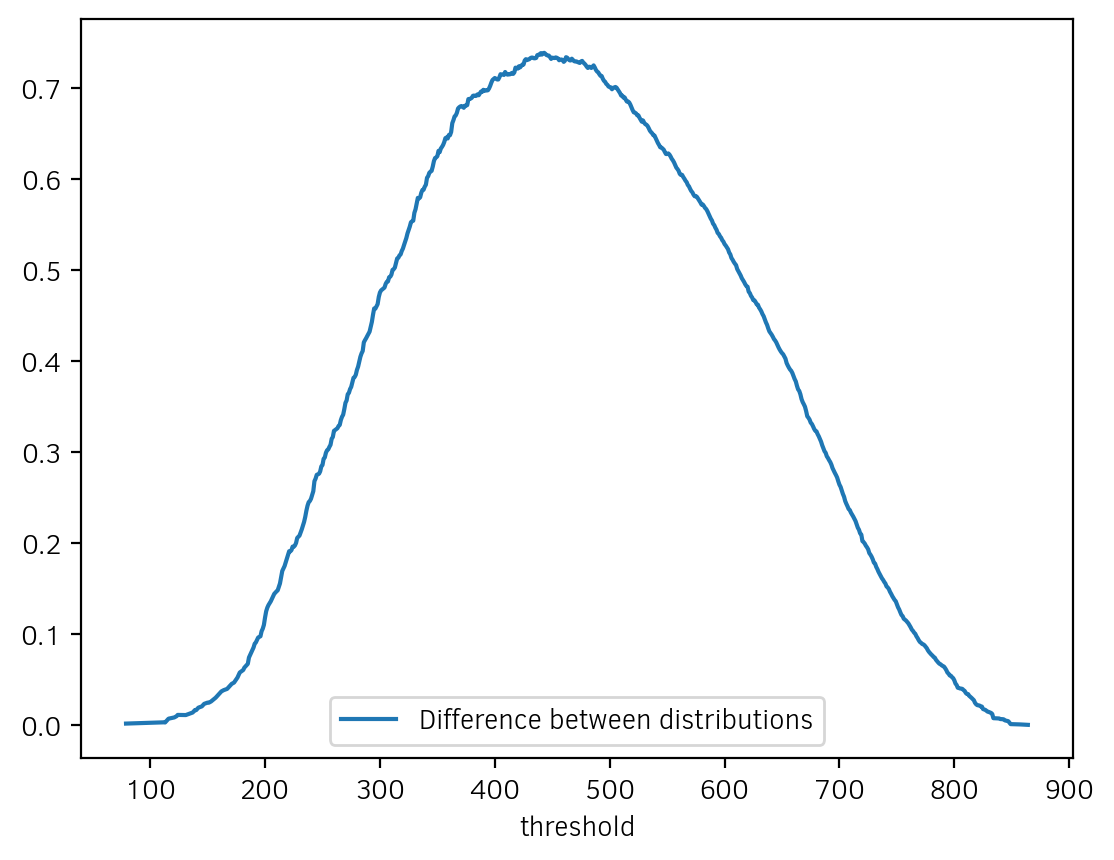

In [11]:
%config InlineBackend.figure_format = 'retina'

dataframe_viz = pd.DataFrame(
    {
        'is_bad': y.loc[ix_train],
        'score': scorecard.score(X.loc[ix_train])
    }
)

# Selecting the threshold
thresholds = sorted(dataframe_viz['score'].unique(), reverse=True)

thresholds_ar = {'threshold': [], 'share_bads': [], 'share_goods': []}

total_defaults = dataframe_viz['is_bad'].sum()
total_non_defaults = len(dataframe_viz) - total_defaults

for thresh in thresholds:
    share_bads = dataframe_viz[dataframe_viz['score'] <= thresh]['is_bad'].sum() / total_defaults
    share_goods = (1-dataframe_viz[dataframe_viz['score'] <= thresh]['is_bad']).sum() / total_non_defaults
    thresholds_ar['threshold'].append(thresh)
    thresholds_ar['share_bads'].append(share_bads)
    thresholds_ar['share_goods'].append(share_goods)

thresholds_ar_df = pd.DataFrame(thresholds_ar)

# difference between %bads and %goods
thresholds_ar_df['delta'] = thresholds_ar_df['share_bads'] - thresholds_ar_df['share_goods']
display(thresholds_ar_df[thresholds_ar_df['delta'] == thresholds_ar_df['delta'].max()])
threshold_value_woe_lr = thresholds_ar_df[thresholds_ar_df['delta'] == thresholds_ar_df['delta'].max()]['threshold'].item()
thresholds_ar_df.plot(x='threshold', y='delta', label='Difference between distributions')

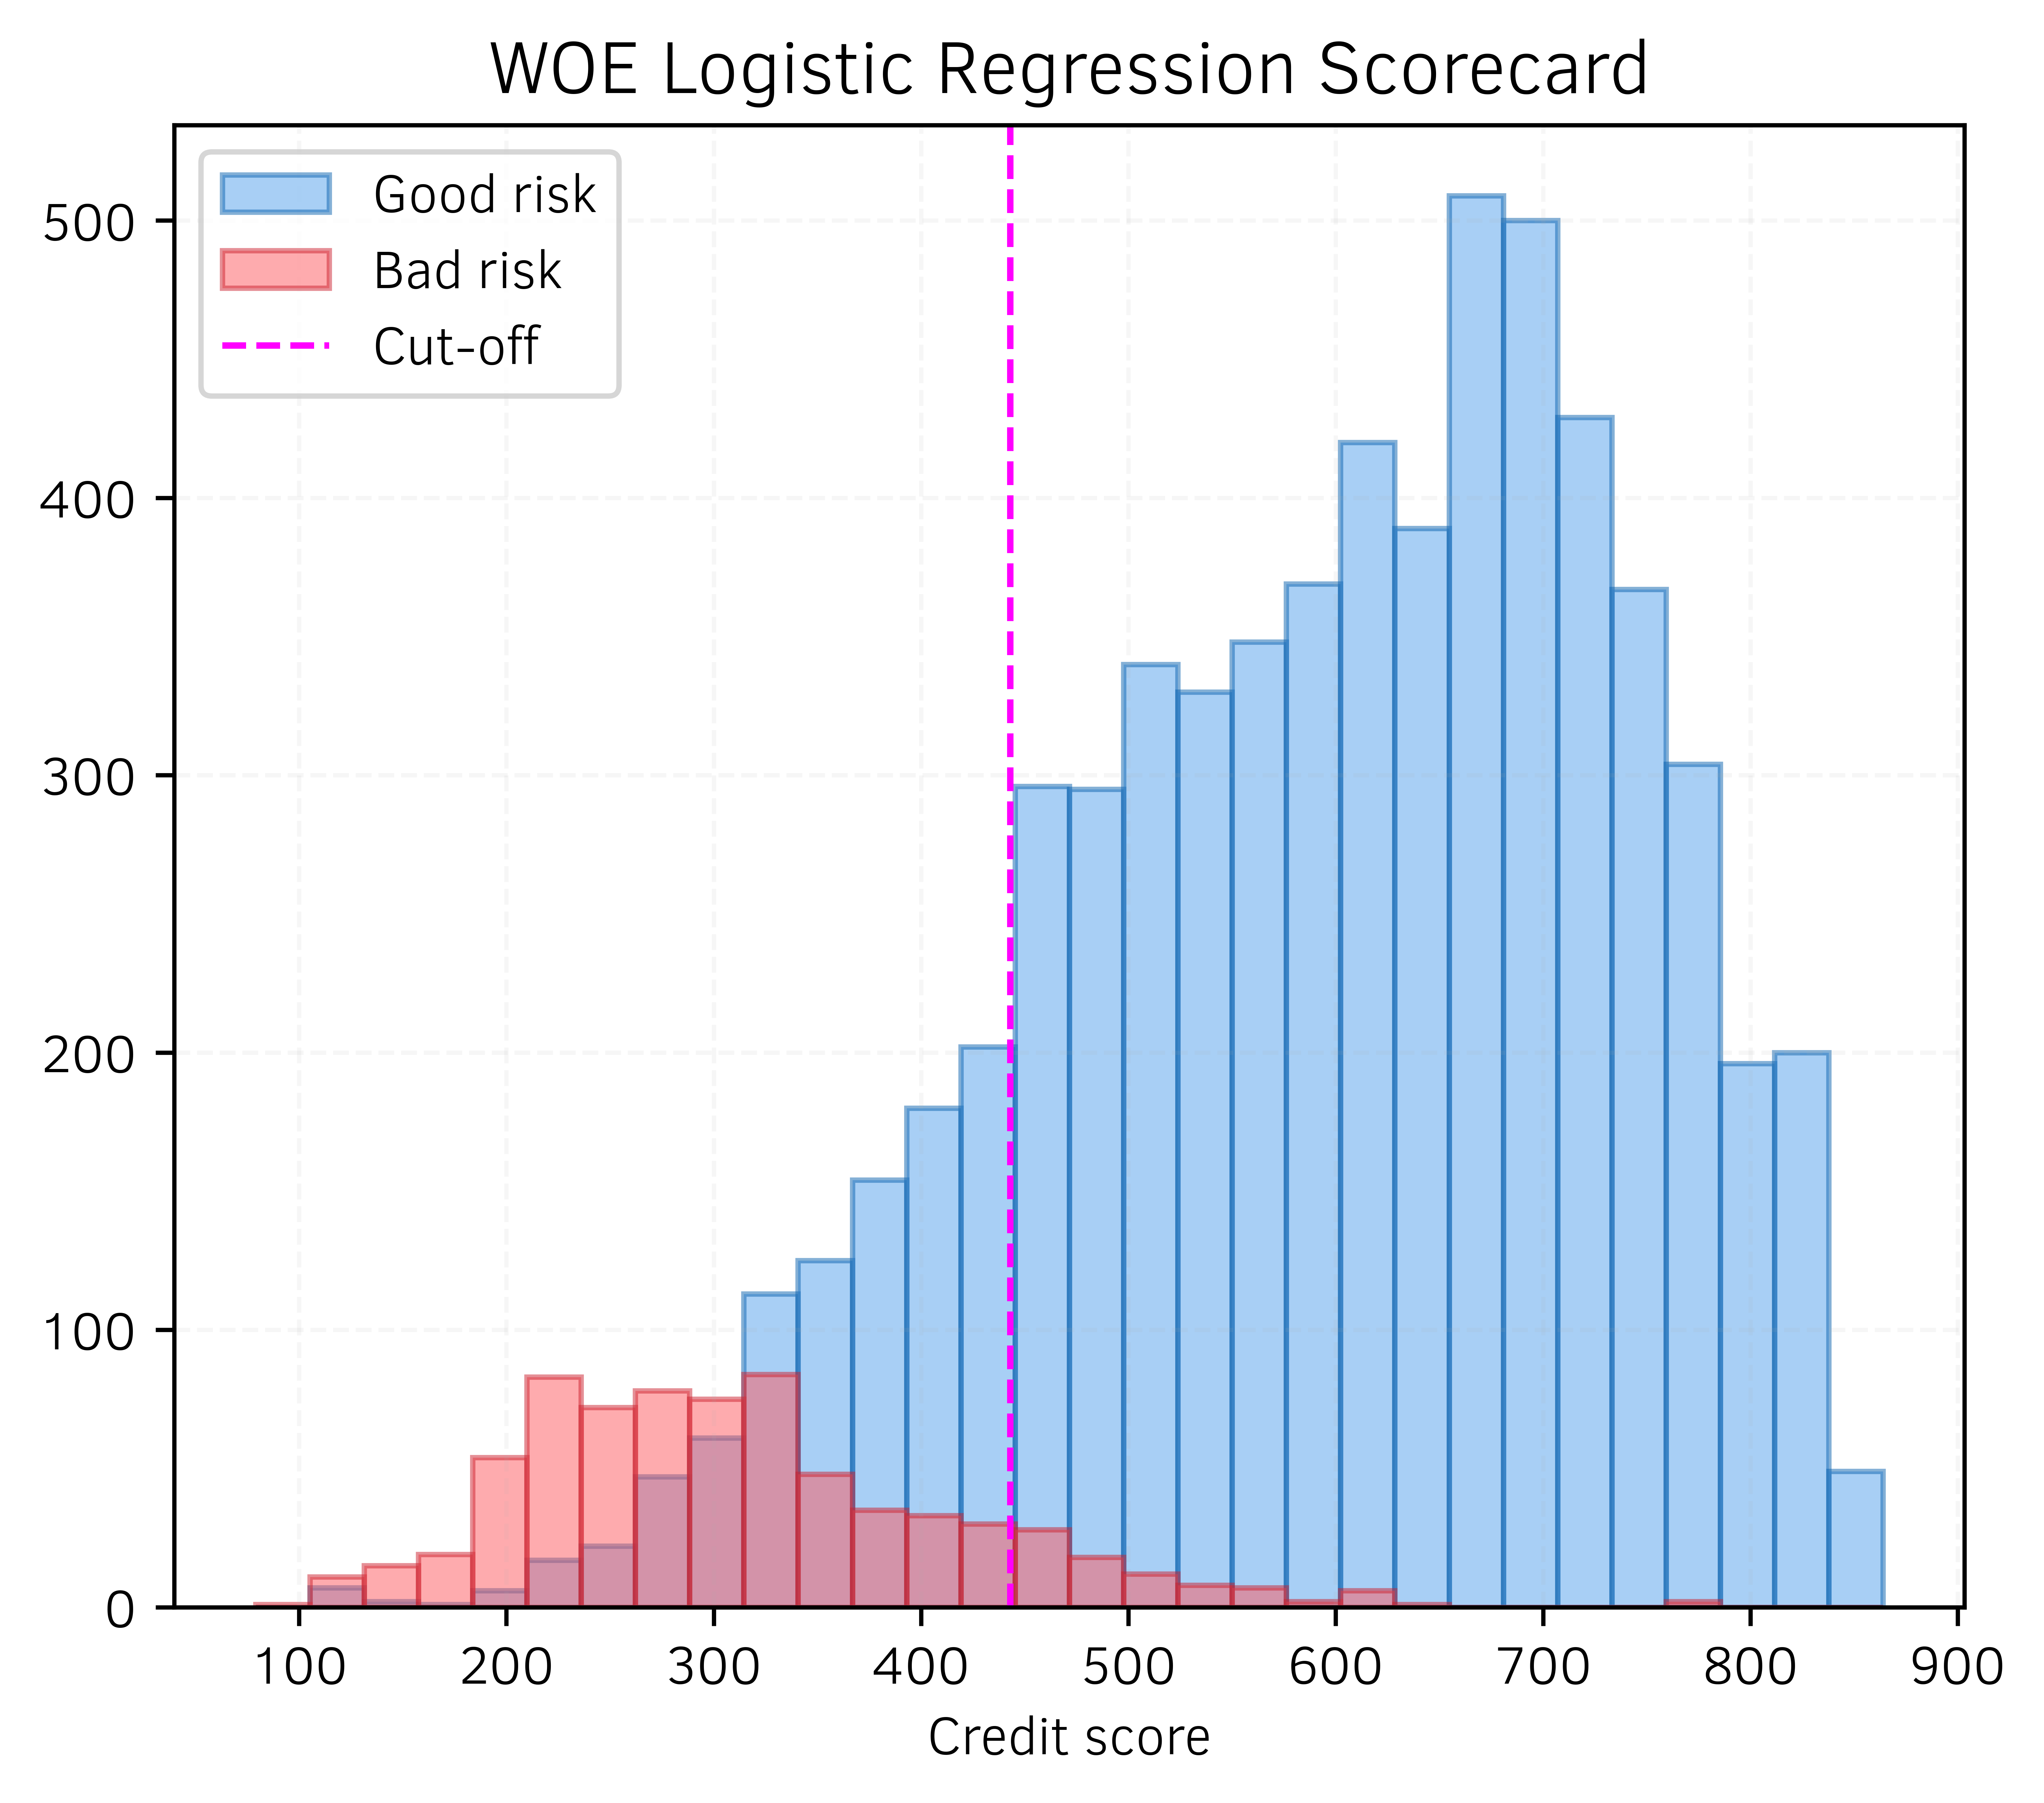

In [22]:
from matplotlib import pyplot as plt
import numpy as np

# Determine the range of scores
score_min = dataframe_viz['score'].min().min()
score_max = dataframe_viz['score'].max().max()

# Define the number of bins and bin width
num_bins = 30
bin_width = (score_max - score_min) / num_bins

filter_bads = (dataframe_viz['is_bad'] == 1)
model_name = 'score'

plt.figure(figsize=(6,5), dpi=600)
_ = plt.hist(
    dataframe_viz[~filter_bads][model_name].sample(frac=1.0, replace=True),
    label="Good risk",
    color="#52a1ec",
    edgecolor="#0b62af",
    alpha=0.5,
    bins=np.arange(score_min, score_max + bin_width, bin_width),
)

_ = plt.hist(
    dataframe_viz[filter_bads][model_name].sample(frac=1.0, replace=True),
    label="Bad risk",
    color="#fe595f",
    edgecolor="#cc212e",
    alpha=0.5,
    bins=np.arange(score_min, score_max + bin_width, bin_width),
)
plt.axvline(x=threshold_value_woe_lr, color='fuchsia', linewidth=1.2, linestyle='--', label='Cut-off')
plt.legend()
plt.title('WOE Logistic Regression Scorecard', fontsize=14)
plt.xlabel('Credit score')
plt.grid(alpha=0.1, linestyle='--')

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Boosted Scorecard</span>

In [23]:
import xgboost as xgb

best_params = dict(
    n_estimators=100,
    learning_rate=0.55,
    max_depth=1,
    gamma=0.1,
    subsample=0.95,
    colsample_bytree=0.57,
    min_child_weight=21,
    alpha=2.92,
    grow_policy='depthwise'
)

xgb_model = xgb.XGBClassifier(**best_params)

X_replaced = X.replace([-9, -8, -7], np.nan)

xgb_model.fit(X_replaced.loc[ix_train], y.loc[ix_train])

predictions = xgb_model.predict_proba(X_replaced.loc[ix_train])[:,1]
gini = roc_auc_score(y.loc[ix_train], predictions) * 2 - 1 # type: ignore
print(f"Gini train score: {gini:.2%}")

predictions = xgb_model.predict_proba(X_replaced.loc[ix_test])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
print(f"Gini test score: {gini:.2%}")

Gini train score: 89.86%
Gini test score: 89.44%


In [24]:
from utils import XGBoostTreeParser, get_credit_scores

bstr_xgb = xgb_model.get_booster()
xgb_tree_parser = XGBoostTreeParser(bstr_xgb)
scorecard_xgb = xgb_tree_parser.generate_scorecard(
    bstr_xgb, PDO=40, standardSc_pts=500, standardSc_odds=19
)
score_xgb = get_credit_scores(X.loc[ix_test], X.columns.to_list(), scorecard_xgb)

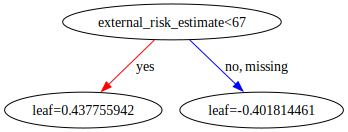

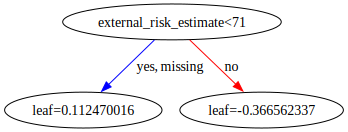

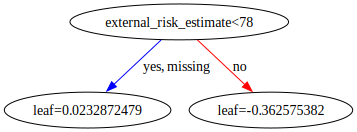

In [25]:
# show individual estimators
for tree_i in range(0,3):
    display(xgb.to_graphviz(xgb_model, num_trees=tree_i, rankdir='TD'))

In [26]:
scorecard_xgb[scorecard_xgb.index <= 8][
    ['Feature', 'Sign', 'Split', 'XAddEvidence', 'Points']]

,Feature,Sign,Split,XAddEvidence,Points
Tree,,,,,
0,external_risk_estimate,<,67.000000,0.437756,0
0,external_risk_estimate,>=,67.000000,-0.401814,48
1,external_risk_estimate,<,71.000000,0.112470,0
1,external_risk_estimate,>=,71.000000,-0.366562,28
2,external_risk_estimate,<,78.000000,0.023287,0
2,external_risk_estimate,>=,78.000000,-0.362575,22
3,account_never_delinq_percent,<,97.699997,0.651601,0
3,account_never_delinq_percent,>=,97.699997,-0.600417,72
4,revolving_utilization_of_unsecured_lines,<,0.531367,-0.398247,53


,threshold,share_bads,share_goods,delta
375,489.0,0.922438,0.1518,0.770638


<Axes: xlabel='threshold'>

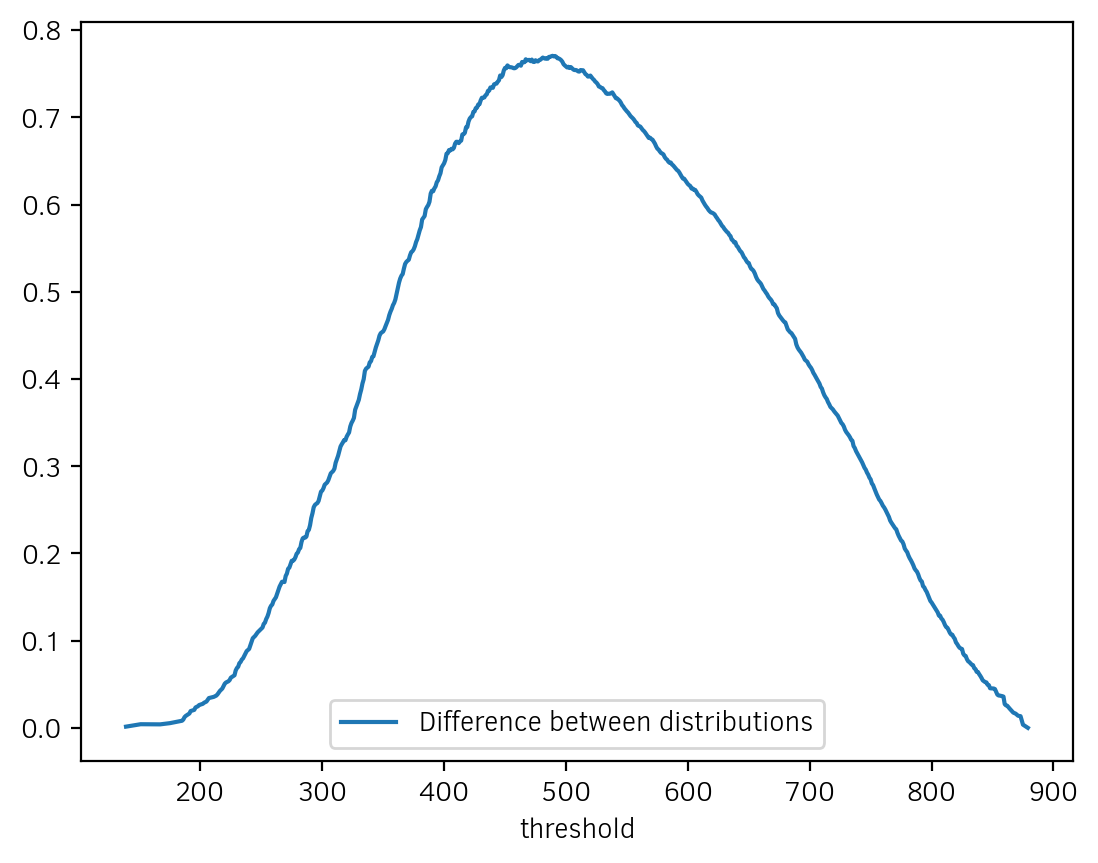

In [27]:
dataframe_viz = pd.DataFrame(
    {
        'is_bad': y.loc[ix_train],
        'score': get_credit_scores(X.loc[ix_train], X.columns.to_list(), scorecard_xgb)['Score']
    }
)

# Selecting the threshold
thresholds = sorted(dataframe_viz['score'].unique(), reverse=True)

thresholds_ar = {'threshold': [], 'share_bads': [], 'share_goods': []}

total_defaults = dataframe_viz['is_bad'].sum()
total_non_defaults = len(dataframe_viz) - total_defaults

for thresh in thresholds:
    share_bads = dataframe_viz[dataframe_viz['score'] <= thresh]['is_bad'].sum() / total_defaults
    share_goods = (1-dataframe_viz[dataframe_viz['score'] <= thresh]['is_bad']).sum() / total_non_defaults
    thresholds_ar['threshold'].append(thresh)
    thresholds_ar['share_bads'].append(share_bads)
    thresholds_ar['share_goods'].append(share_goods)
    
thresholds_ar_df = pd.DataFrame(thresholds_ar)

# difference between %bads and %goods
thresholds_ar_df['delta'] = thresholds_ar_df['share_bads'] - thresholds_ar_df['share_goods']
display(thresholds_ar_df[thresholds_ar_df['delta'] == thresholds_ar_df['delta'].max()])
threshold_value_xgb = thresholds_ar_df[thresholds_ar_df['delta'] == thresholds_ar_df['delta'].max()]['threshold'].item()
thresholds_ar_df.plot(x='threshold', y='delta', label='Difference between distributions')

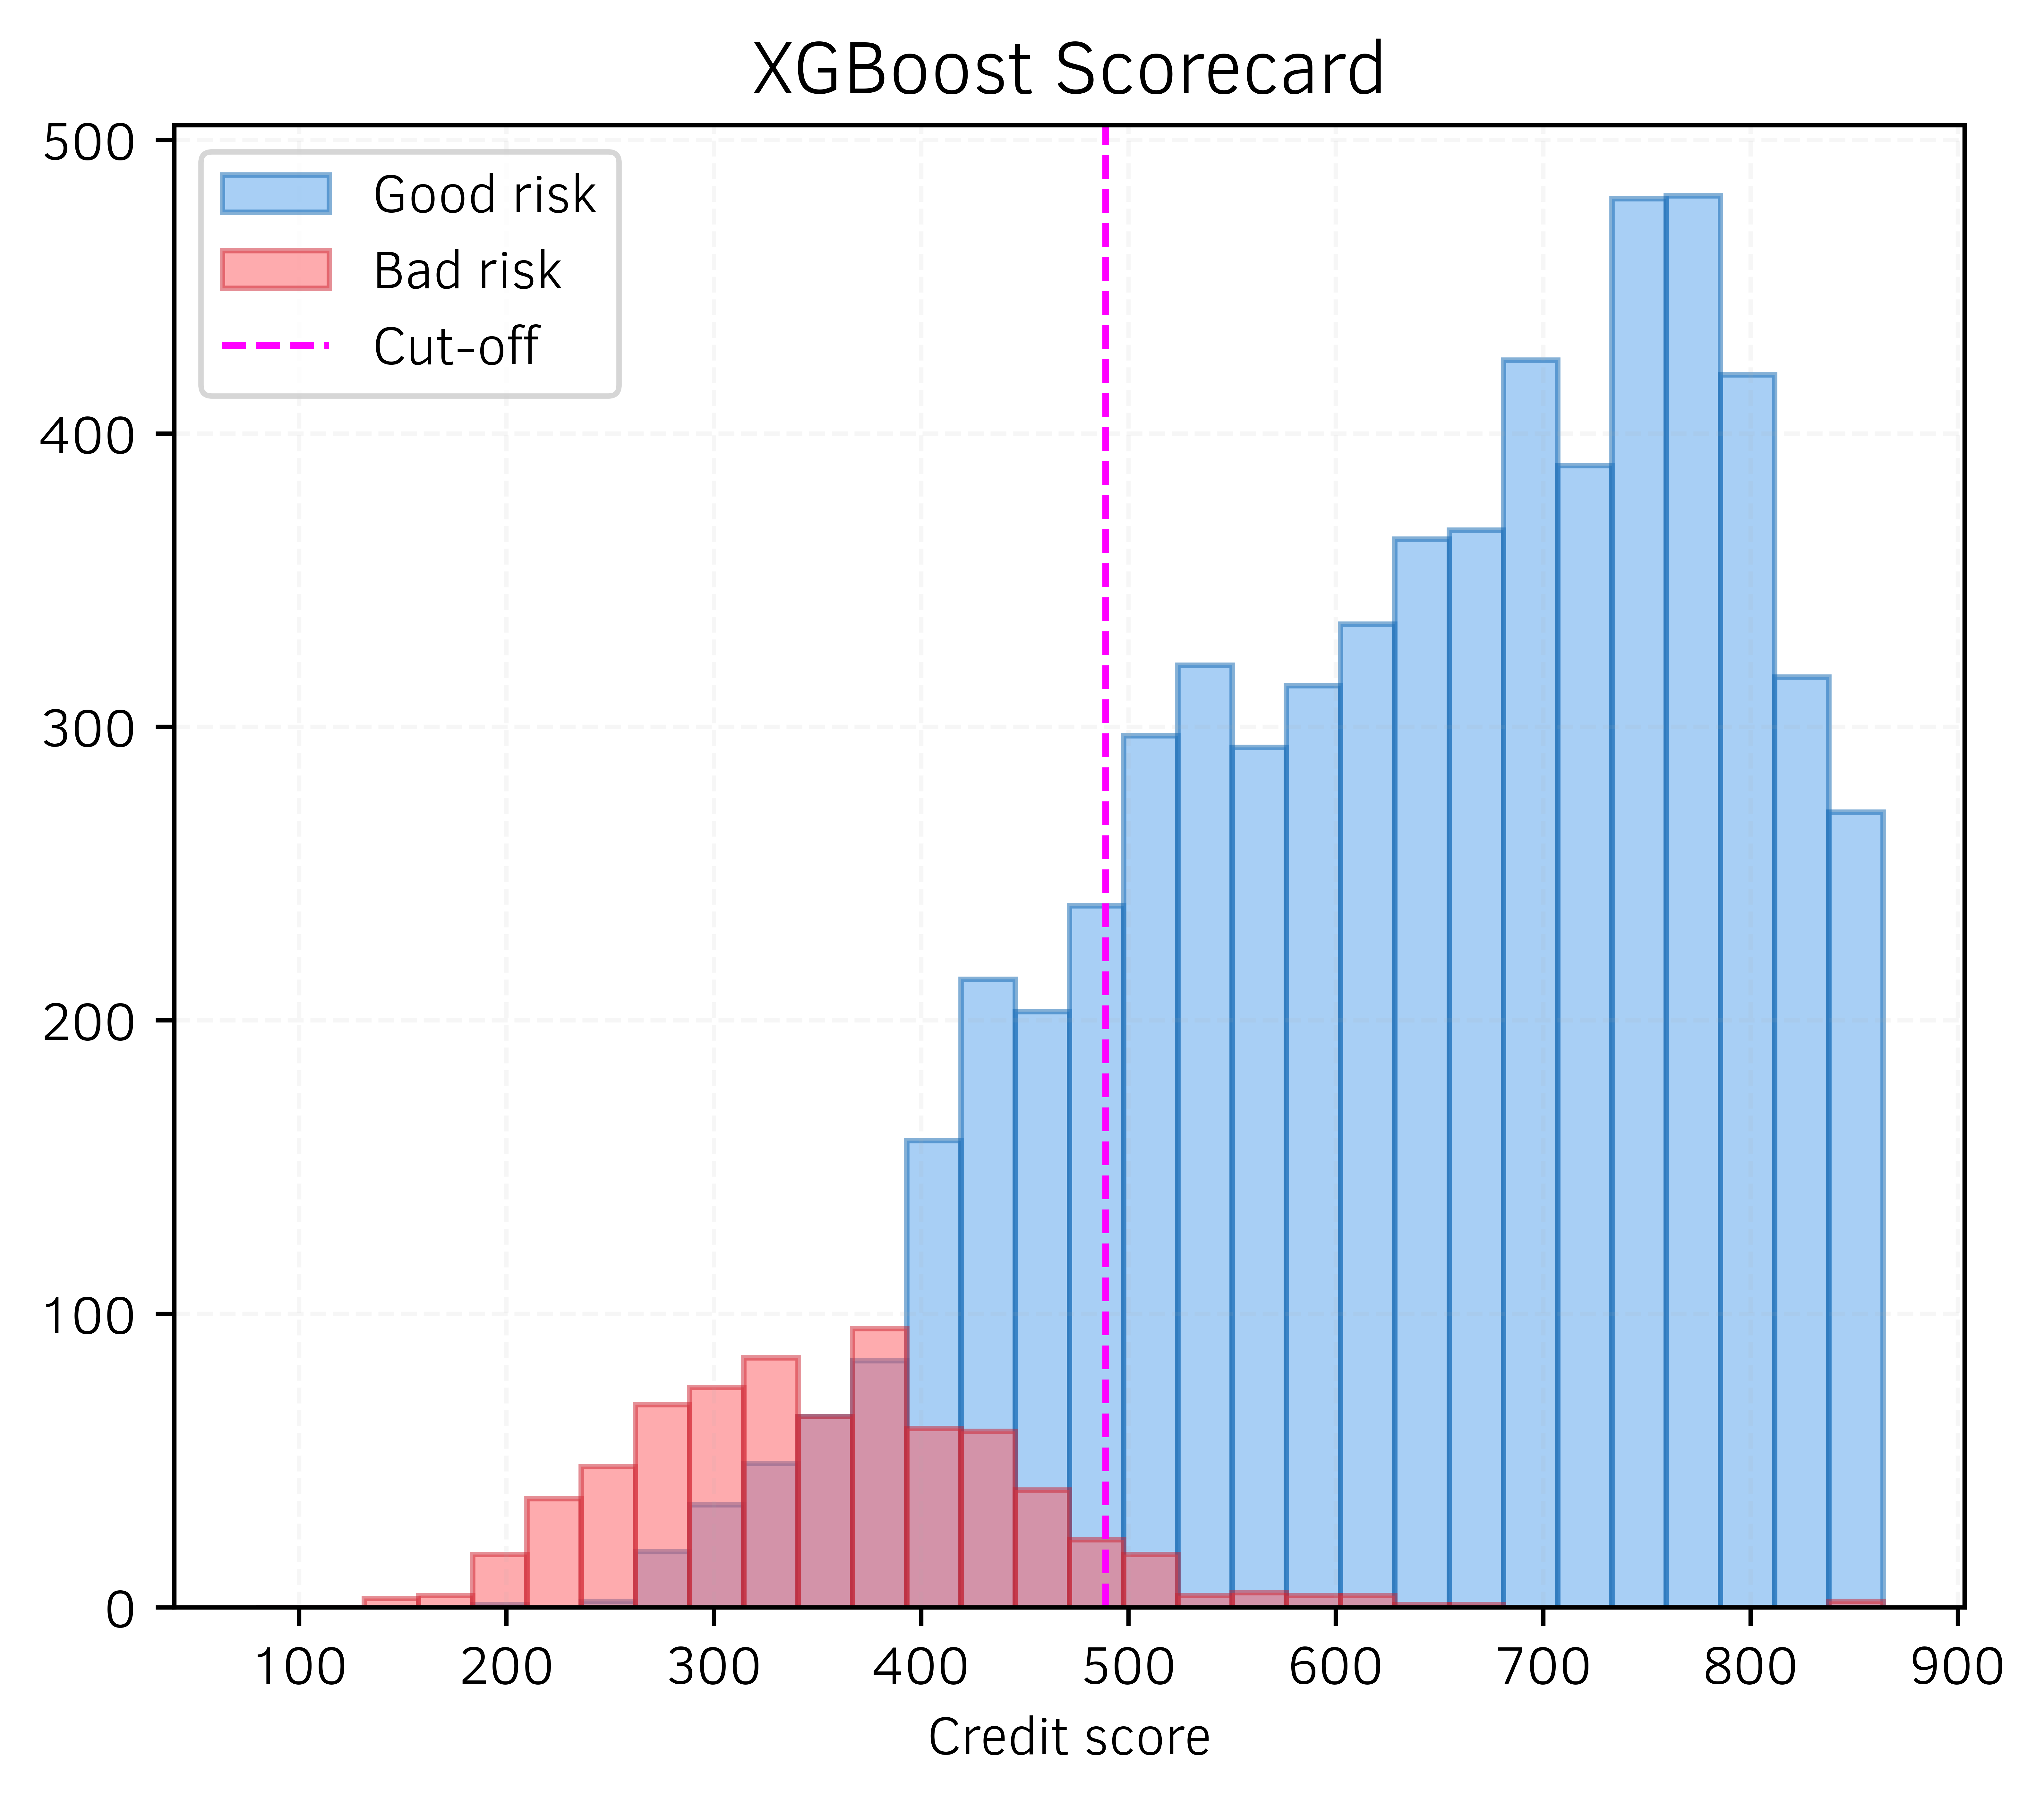

In [28]:
from matplotlib import pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Determine the range of scores
# score_min = dataframe_viz['score'].min().min()
# score_max = dataframe_viz['score'].max().max()

# # Define the number of bins and bin width
# num_bins = 30
# bin_width = (score_max - score_min) / num_bins

filter_bads = (dataframe_viz['is_bad'] == 1)
model_name = 'score'

plt.figure(figsize=(6,5), dpi=600)
_ = plt.hist(
    dataframe_viz[~filter_bads][model_name].sample(frac=1.0, replace=True),
    label="Good risk",
    color="#52a1ec",
    edgecolor="#0b62af",
    alpha=0.5,
    bins=np.arange(score_min, score_max + bin_width, bin_width),
)

_ = plt.hist(
    dataframe_viz[filter_bads][model_name].sample(frac=1.0, replace=True),
    label="Bad risk",
    color="#fe595f",
    edgecolor="#cc212e",
    alpha=0.5,
    bins=np.arange(score_min, score_max + bin_width, bin_width),
)
plt.axvline(x=threshold_value_xgb, color='fuchsia', linewidth=1.2, linestyle='--', label='Cut-off')
plt.legend()
plt.title('XGBoost Scorecard', fontsize=14)
plt.xlabel('Credit score')
plt.grid(alpha=0.1, linestyle='--')

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Performance</span>

In [29]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utils import plot_cap

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_2075/1119614273.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Set2")


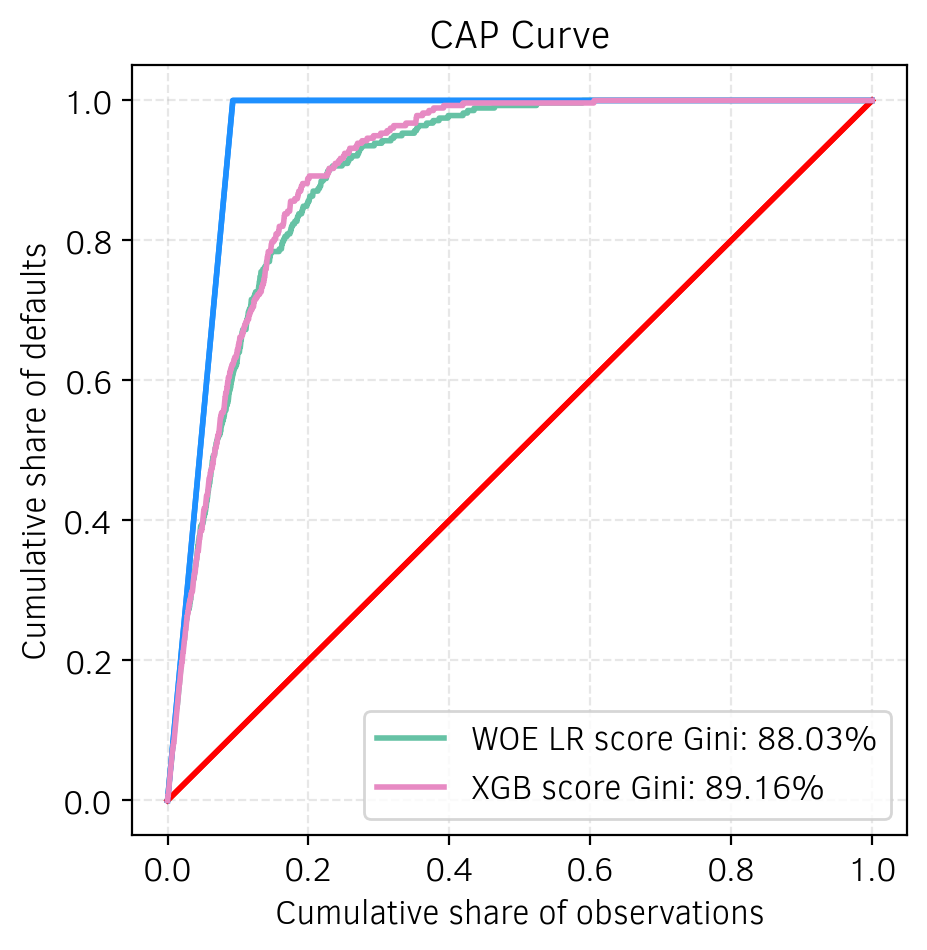

In [30]:
# Discriminatory power
fig = plt.figure(figsize=(5, 5), dpi=100)
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Set2")

woe_lr_score = scorecard.score(X.loc[ix_test])
xgb_score = get_credit_scores(X.loc[ix_test], X.columns.to_list(), scorecard_xgb)['Score']

gini_score_woe_lr = roc_auc_score(y.loc[ix_test], -woe_lr_score) * 2 - 1
gini_score_xgb = roc_auc_score(y.loc[ix_test], -xgb_score) * 2 - 1

plot_cap(
    y.loc[ix_test],
    -woe_lr_score,
    legend_title=f"WOE LR score Gini: {gini_score_woe_lr:.2%}",
    line_color=colors(0),
)
plot_cap(
    y.loc[ix_test],
    -xgb_score,
    legend_title=f"XGB score Gini: {gini_score_xgb:.2%}",
    line_color=colors(3),
)

plt.grid(alpha=0.3, linestyle='--')
plt.tick_params(labelsize=12)

plt.xlabel("Cumulative share of observations", fontsize=12)
plt.ylabel("Cumulative share of defaults", fontsize=12)

plt.title("CAP Curve", fontsize=14)
plt.legend(fontsize=12)
# plt.savefig('discrimination.png', bbox_inches='tight')
plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Swap-in Swap-Out</span>

In [31]:
# Create scores
dataset['woe_lr_score'] = scorecard.score(dataset)
dataset['xgb_score'] = get_credit_scores(
    dataset, 
    X.columns.to_list(), 
    scorecard_xgb
)['Score']

# Set cut-offs
dataset['woe_lr_score_decision'] = np.where(
    dataset['woe_lr_score'] < threshold_value_woe_lr, 'Declined', 'Approved'
)

dataset['xgb_score_decision'] = np.where(
    dataset['xgb_score'] < threshold_value_xgb, 'Declined', 'Approved'
)

In [32]:
swap_set = pd.crosstab(
    dataset['woe_lr_score_decision'], 
    dataset['xgb_score_decision']
)

In [33]:
# Calculate totals for rows and columns
row_totals = swap_set.sum(axis=1)
col_totals = swap_set.sum(axis=0)

# Calculate approval rates
approval_ratio_woe_lr = swap_set.loc['Approved', 'Approved'] / row_totals['Approved']
approval_ratio_xgb = swap_set.loc['Approved', 'Approved'] / col_totals['Approved']

# Calculate rejection rates
rejection_ratio_woe_lr = swap_set.loc['Declined', 'Declined'] / row_totals['Declined']
rejection_ratio_xgb = swap_set.loc['Declined', 'Declined'] / col_totals['Declined']

data = {
    'Metric': ['Approval Rate', 'Rejection Rate'],
    'WOE LR Score': [
        f"{approval_ratio_woe_lr:.2%}",
        f"{rejection_ratio_woe_lr:.2%}",
    ],
    'XGB Score': [
        f"{approval_ratio_xgb:.2%}",
        f"{rejection_ratio_xgb:.2%}",
    ]
}

ratios_table = pd.DataFrame(data)
ratios_table.set_index('Metric', inplace=True)

ratios_table

,WOE LR Score,XGB Score
Metric,,
Approval Rate,97.37%,97.81%
Rejection Rate,92.45%,91.03%


In [34]:
# Calculate bad rates instead of counts using pivot_table
pivot_bad_rates = dataset.pivot_table(
    index="woe_lr_score_decision",
    columns="xgb_score_decision",
    values="is_bad",
    aggfunc="sum"
)

# Display the pivot table showing bad rates
pivot_bad_rates["Total"] = pivot_bad_rates.sum(axis=1)
pivot_bad_rates.loc["Total"] = pivot_bad_rates.sum()

pivot_bad_rates = round(pivot_bad_rates / np.sum(dataset.is_bad), 2)

styled_table = pivot_bad_rates.style.format("{:.0%}")
row_index = 2  # Row index 2 corresponds to XGB
col_index = 0  # Column index 0 corresponds to WOE LR

# Apply style to the specified element
styled_table.applymap(
    lambda x: "background-color: lime" if (x == pivot_bad_rates.iloc[2, 0]) else "",
    subset=pd.IndexSlice[[pivot_bad_rates.index[2]], [pivot_bad_rates.columns[0]]],
).applymap(
    lambda x: "background-color: lime" if (x == pivot_bad_rates.iloc[0, 2]) else "",
    subset=pd.IndexSlice[[pivot_bad_rates.index[0]], [pivot_bad_rates.columns[2]]],
)


xgb_score_decision,Approved,Declined,Total
woe_lr_score_decision,,,
Approved,8%,4%,11%
Declined,1%,88%,89%
Total,9%,91%,100%


<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Feature importance</span>

[13:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


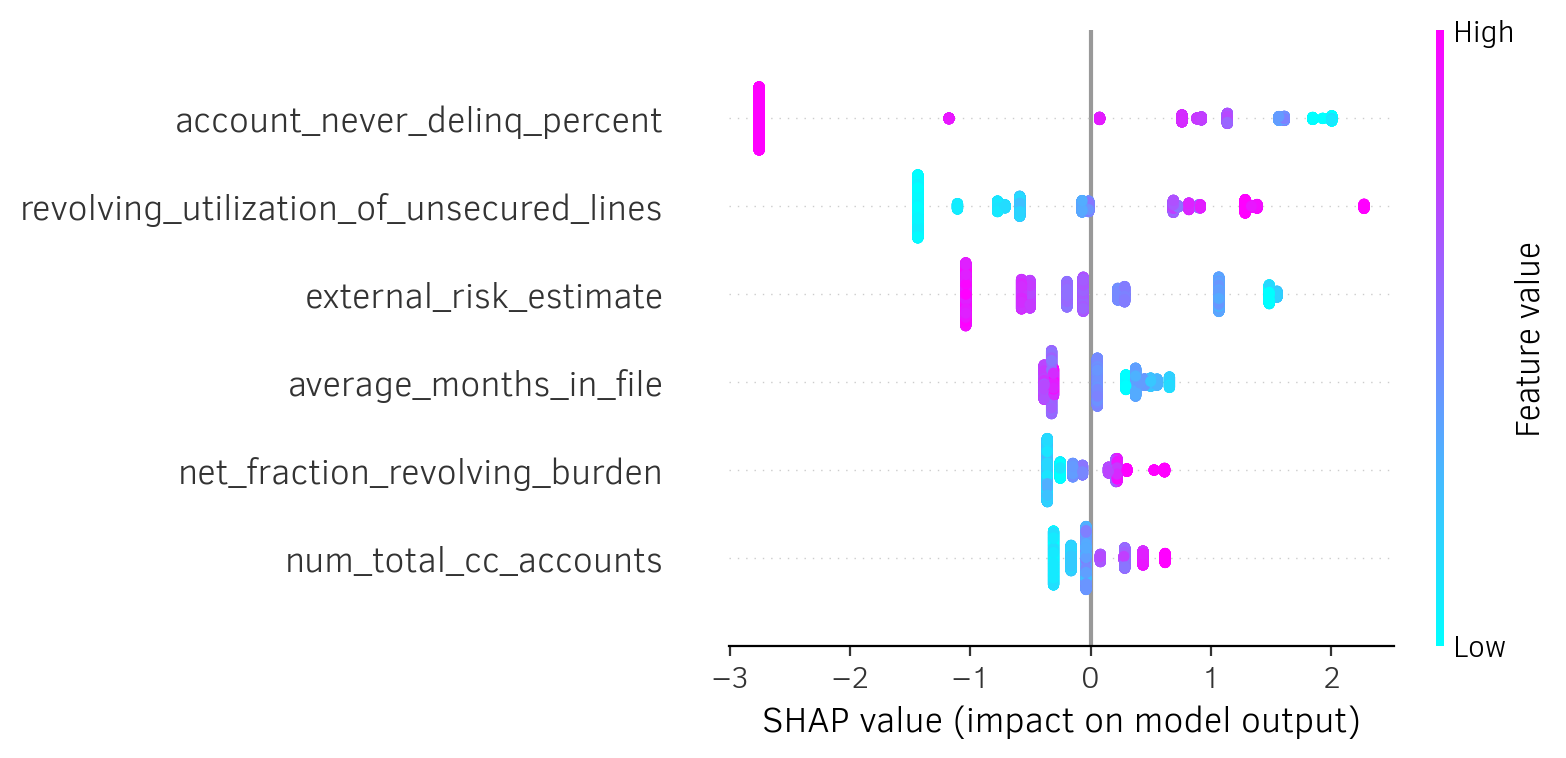

In [35]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X.loc[ix_test])

shap.summary_plot(
    shap_values, 
    X.loc[ix_test],
    cmap = "cool"
)

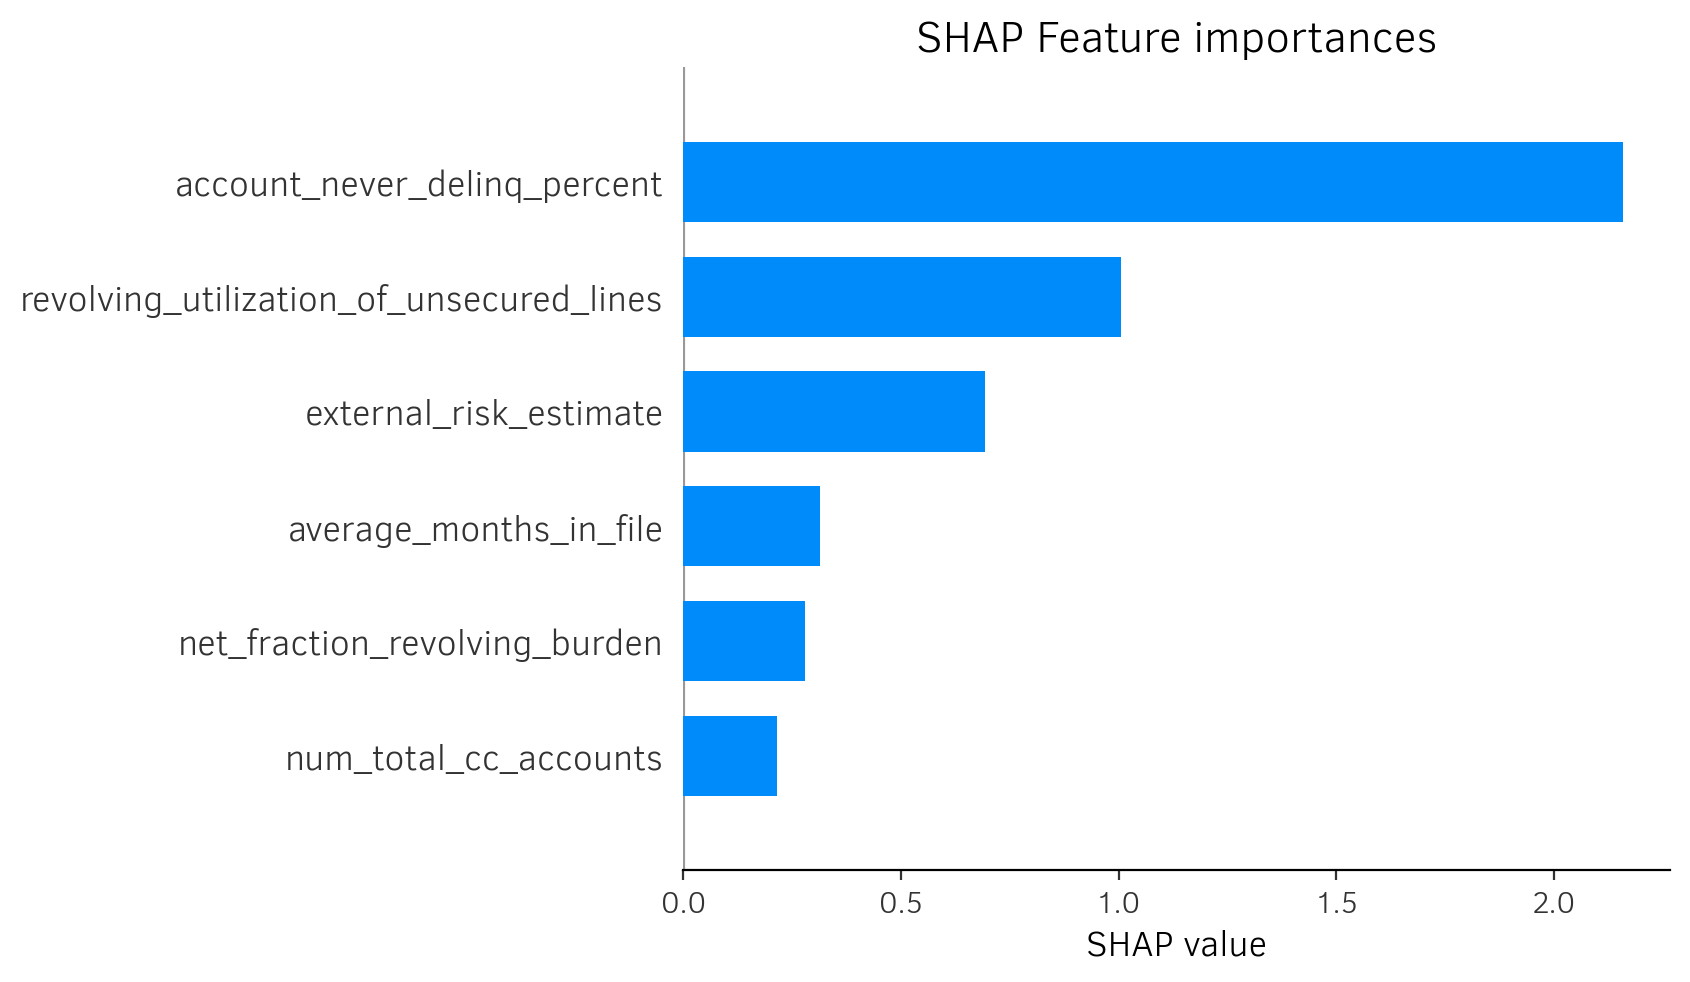

In [36]:
from matplotlib import pyplot as plt
import shap
shap.initjs()

# Get a Booster
booster = xgb_model.get_booster()
# Wrapping the test X into a DMatrix, needed by Booster
shap_values = booster.predict(xgb.DMatrix(X.loc[ix_test]), pred_contribs=True)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X.columns,
    plot_type="bar",
    # plot_size=[10,5],
    show=False
    )
plt.title("SHAP Feature importances", fontsize=16) 
plt.xlabel("SHAP value")
plt.gcf().set_size_inches(9,5)
plt.show()

In [37]:
feats = score_xgb.columns.to_list()
feats.remove("Score")

importances = {"Feature": [], "Importance": []}

for feat in feats:
    importance = (score_xgb[feat] / score_xgb['Score']).mean()
    importances["Feature"].append(feat)
    importances["Importance"].append(importance)

bstr_importances = pd.DataFrame(importances).sort_values(
    by="Importance", ascending=True
)
# select top 7 features
bstr_importances_top = bstr_importances.sort_values(
    by="Importance", 
    ascending=False
)[0:10]

top_imp = bstr_importances_top.iloc[:, 0].to_list()

fig, ax = plt.subplots(figsize=(7, 5), dpi=600)
bstr_importances[bstr_importances["Feature"].isin(top_imp)].plot(
    kind="barh",
    width=0.65,
    color="#0090ff",
    title=None,
    alpha=1.0,
    x="Feature",
    legend=False,
    xlabel=None,
    fontsize=12,
    ax=ax,
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Removing ticks and changing left and bottom axis spine color
ax.tick_params(axis='both', which='both', length=0)  # Remove ticks
ax.spines['left'].set_color('grey')  # Set left spine color
ax.spines['bottom'].set_color('grey')  # Set bottom spine color

plt.ylabel("")
plt.title('XGBoost Scorecard Importances', fontsize=16)
plt.tight_layout()
plt.xlabel('Importance (score contribution)', fontsize=12)
# fig.savefig('custom_importance.png', bbox_inches='tight', dpi=600)

Text(0.5, 175.49999999999991, 'Importance (score contribution)')